In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [47]:
with open("experiment_config_results","rb") as current_file:
    experiment_config_results = dill.load(current_file)
with open("experiments","rb") as current_file:
    experiments = dill.load(current_file)

    
non_unique_params = np.array([experiment['parameter'] for experiment in experiments])
non_unique_config_strings = np.array([experiment['config_string'] for experiment in experiments])

par_indices = np.unique(non_unique_params,return_index=True)[1]
string_indices = np.unique(non_unique_config_strings,return_index=True)[1]

parameters = non_unique_params[np.sort(par_indices)]
config_strings = non_unique_config_strings[np.sort(string_indices)]
# config_strings[0],config_strings[1],config_strings[2] = config_strings[2],config_strings[0],config_strings[1]
config_strings[[0,1,2]] = config_strings[[2,0,1]]
print(config_strings)

def str_noneguard(obj):
    if hasattr(obj,'__name__'):
        return obj.__name__
    if obj is None:
        return ''
    if isinstance(obj,list):
        return str([str_noneguard(x) for x in obj])
    return str(obj)


print(len(config_strings))
colors=['#4285F4','#EA4335', '#FBBC04',  '#34A853','#000000','#46BDC6',      '#46BDC6',             '#F4CCCC','#C9DAF8',            'grey','purple']
print(len(colors))
print(config_strings)
print("")
print("")

print(parameters)
print("")

parameters[[3,4,5,6,7,8,9,10,11,12]] = parameters[[-4,-3,-2,5,3,4,6,8,-1,7]]
print(parameters)



['CCEu, SD=4' 'CCE, SD=4' 'JSD, SD=4' 'CCE, SD=100' 'JSD, SD=100'
 'JSD(5), SD=100' 'JSD(5)' 'MSE, SD=4' 'MSE, SD=100' 'KLD, SD=4'
 'KLD, SD=100']
11
11
['CCEu, SD=4' 'CCE, SD=4' 'JSD, SD=4' 'CCE, SD=100' 'JSD, SD=100'
 'JSD(5), SD=100' 'JSD(5)' 'MSE, SD=4' 'MSE, SD=100' 'KLD, SD=4'
 'KLD, SD=100']


['training_method' 'activation_types' 'input_layer_type' 'encoding_dim'
 'hidden_layers' 'activity_regularizer' 'sigma' 'BN_size'
 'labeled_data_percentage' 'kernel_landmarks' 'CNN_kernel_size'
 'CNN_filters' 'sampling_density']

['training_method' 'activation_types' 'input_layer_type'
 'kernel_landmarks' 'CNN_kernel_size' 'CNN_filters' 'activity_regularizer'
 'encoding_dim' 'hidden_layers' 'sigma' 'labeled_data_percentage'
 'sampling_density' 'BN_size']


In [48]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def plot_vals(i,ylim=[-175,100]):
    fig, ax = plt.subplots(figsize=[10,6])
#     ax.set_color_cycle(['red', 'yellow', 'blue','green','black','teal'])
#     ax.set_prop_cycle(color=['#4285F4','#FBBC04','#EA4335','#34A853','#000000','#46BDC6','#F4CCCC','#C9DAF8','grey','purple'])
    
    parameter = parameters[i]
    ax.set_title(parameter)
    bar=0
    all_numbers = True
    
    for config_index,config_string in enumerate(config_strings):
        color=colors[config_index]
    #     print("--------- " + config_string + " -----------")
        filtered_experiments = [ex for ex in experiments if ex['parameter']==parameter and ex['config_string']==config_string]
        if len(filtered_experiments)==0:
            continue
        mappings = np.array([x['mapping'] for x in filtered_experiments])
        x_values = [x['current_var'] for x in filtered_experiments]
        for x in x_values:
            if not isinstance(x,int) and not isinstance(x,float):
                all_numbers=False

        if not all_numbers:
            for i in range(len(x_values)):
                x_values[i] = str_noneguard(x_values[i])

        results = [result for result in np.array(experiment_config_results,dtype=object)[mappings] ]
        means = np.array([np.mean(x) for x in results])
        sigmas = np.array([np.std(x) for x in results])

    #     print("mappings")
    #     display(mappings)
    #     print("")
    #     print("results")
    #     display(results)
    #     print("")
    #     print("x_values")
    #     display(x_values)
    #     print("")
    #     print("means")
    #     display(means)
    #     print("")
    #     print("sigmas")
    #     display(sigmas)
    #     print("\n\n\n")
    #     ax.plot(x_values,means)
#         print(x_values)
        if all_numbers:
            ax.plot(x_values,means,'o-',label=config_string,color=color)
            ax.fill_between(x_values, (means-sigmas), (means+sigmas),alpha=.2,color=color)
        else:
            n=len(x_values)
            ind = np.arange(n)
            width = 0.1
            position = ind + (width*(1-n)/2) + bar*width
            ax.bar(position,means,width=width,yerr=sigmas,label=config_string,color=color)
            bar+=1
    
    ax.set_ylim(ylim)
    if not all_numbers:
        print(x_values)
        print(ind)
#         ax.axhline(0,"black")
        ax.yaxis.set_major_locator(MultipleLocator(25))    
        ax.grid(axis="y")
        
        plt.xticks(ind, x_values)
    else:
        ax.yaxis.set_major_locator(MultipleLocator(25))
        ax.grid()
    ax.axhline(0,color='black')
    ax.legend()

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=

['supervised', 'supervised_2_percent', 'semi', 'semi_sup_first', 'semi_mixed', 'unsupervised']
[0 1 2 3 4 5]


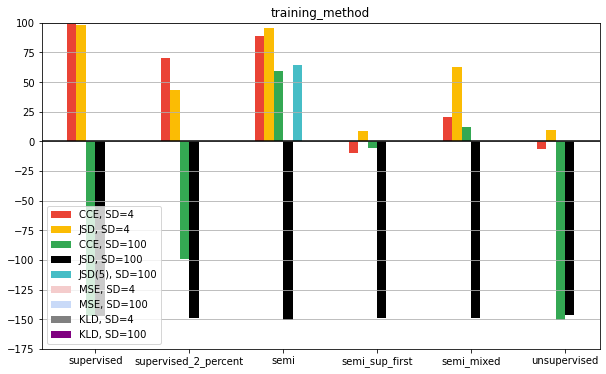

In [49]:
plot_vals(0)

["['sin', 'cos', 'linear', 'relu', 'swish']", "['relu']", "['relu', 'relu', 'relu', 'relu', 'relu']", "['sin', 'cos', 'linear']", "['sin', 'cos', 'linear', 'relu', 'sigmoid']"]
[0 1 2 3 4]


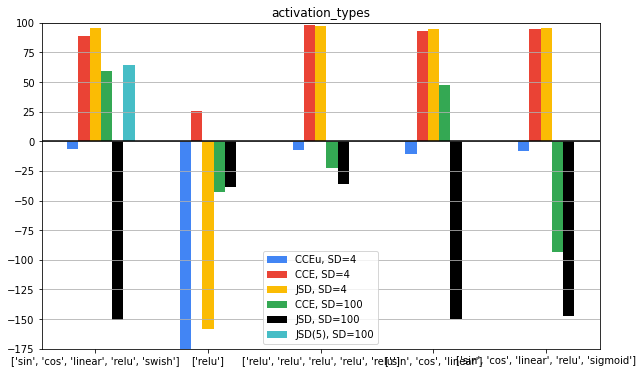

In [50]:
plot_vals(1)

['dense', 'gaussian_noise', 'gaussian_dropout', 'sqrt_softmax', 'gaussian_kernel', 'CNN', 'VAE']
[0 1 2 3 4 5 6]


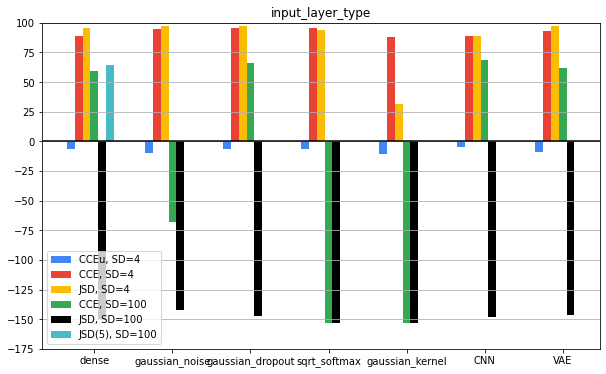

In [51]:
plot_vals(2)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

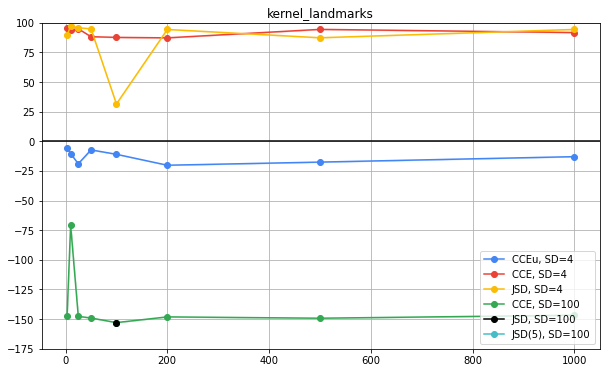

In [52]:
plot_vals(3)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

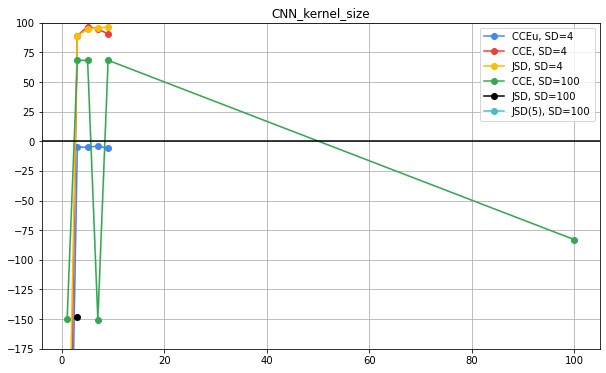

In [53]:
plot_vals(4)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

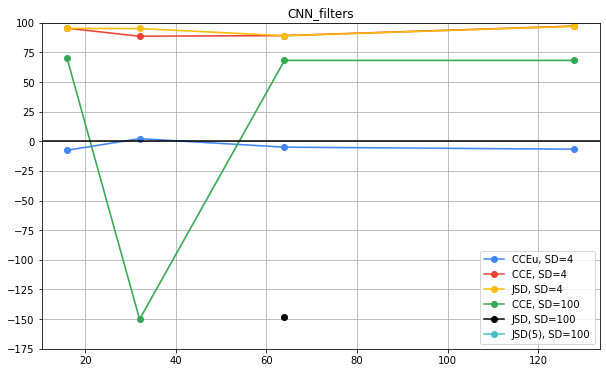

In [54]:
plot_vals(5)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['', 'L2: 0.01', 'L2: 10^-4', 'L1: 0.01', 'L1: 10^-4']
[0 1 2 3 4]


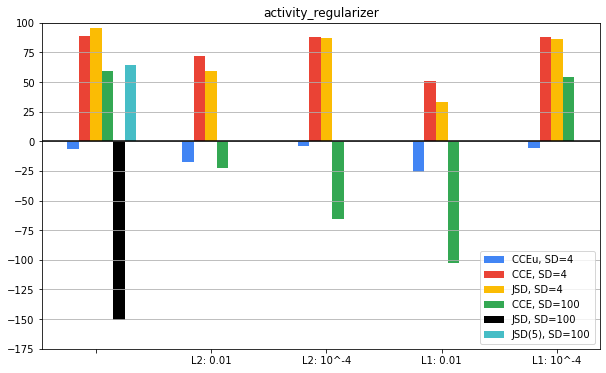

In [55]:
plot_vals(6)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


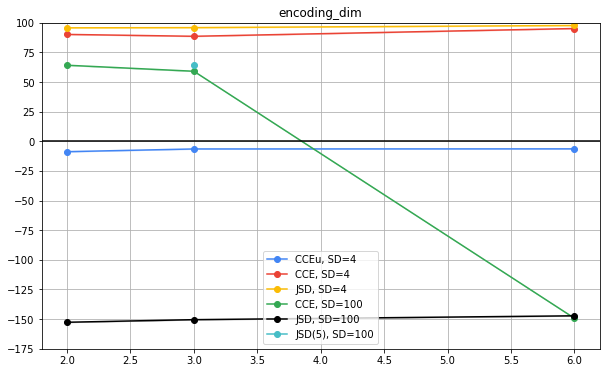

In [56]:
plot_vals(7)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


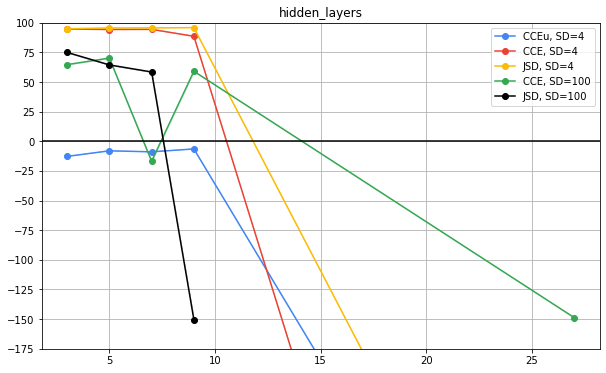

In [57]:
plot_vals(8)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=

['0.01/SD', '(0.01*4)/SD', '0.01/math.sqrt(SD)', '0.01', '0.05', '0.1', '0.2']
[0 1 2 3 4 5 6]


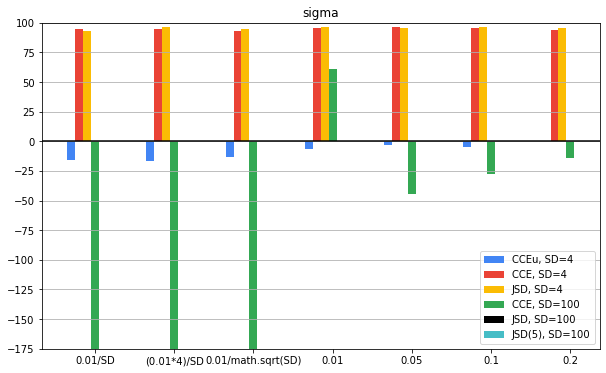

In [58]:
plot_vals(9)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

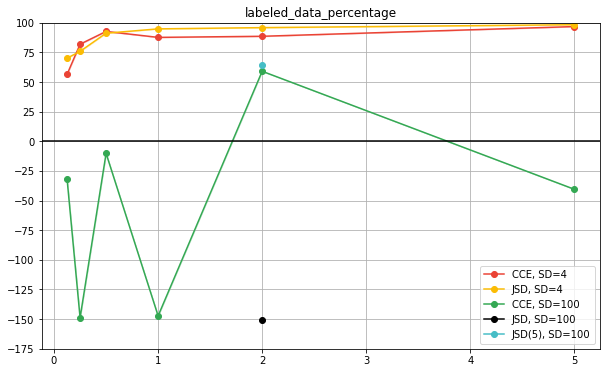

In [59]:
plot_vals(10)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


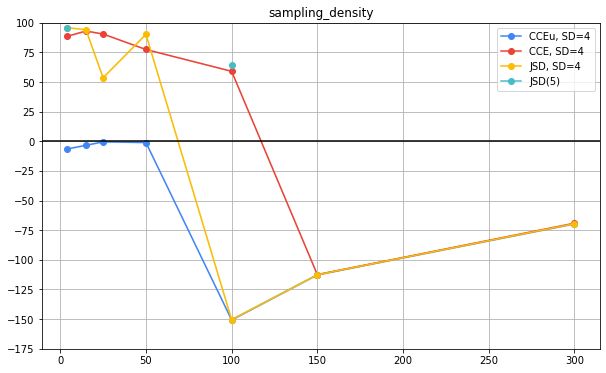

In [60]:
plot_vals(11)

C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\freek\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dt

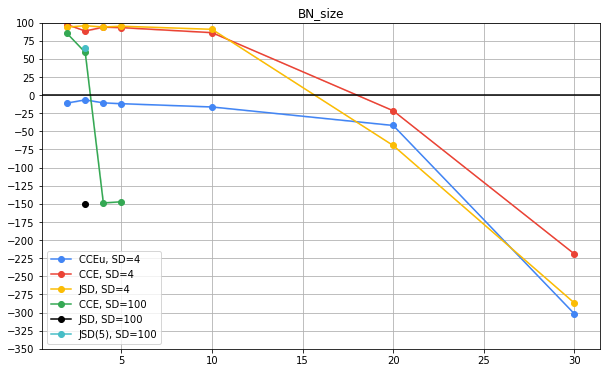

In [61]:
plot_vals(12,ylim=[-350,100])

{'config_string': 'JSD, SD=4',
 'input_dict': {'BN_size': 3,
  'mu': 0,
  'sigma': <function __main__.<lambda>(SD)>,
  'sampling_density': 4,
  'activation_types': [<function tensorflow.python.keras.backend.sin(x)>,
   <function tensorflow.python.keras.backend.cos(x)>,
   <function tensorflow.python.keras.activations.linear(x)>,
   'relu',
   'swish'],
  'hidden_layers': 9,
  'encoding_dim': 3,
  'loss_function': 'JSD',
  'training_method': 'semi',
  'activity_regularizer': None,
  'input_layer_type': 'dense',
  'labeled_data_percentage': 2,
  'epochs': 100,
  'VAE': False,
  'CNN': False,
  'kernel_landmarks': 100,
  'CNN_layers': 1,
  'CNN_filters': 64,
  'CNN_kernel_size': 3},
 'parameter': 'training_method',
 'vars': ['supervised',
  'supervised_2_percent',
  'semi',
  'semi_sup_first',
  'semi_mixed',
  'unsupervised'],
 'current_var': 'supervised_2_percent',
 'config': {'BN_size': 3,
  'mu': 0,
  'sigma': <function __main__.<lambda>(SD)>,
  'sampling_density': 4,
  'activation_ty

[97.80801712916646]

75

In [10]:
# with open("experiment_config_results1","rb") as current_file:
#     experiment_config_results1 = dill.load(current_file)
# with open("experiment_config_results2","rb") as current_file:
#     experiment_config_results2 = dill.load(current_file)

# experiment_config_results = []
# for i in range(len(experiment_config_results1)):
#     exp1 = experiment_config_results1[i]
#     exp2 = experiment_config_results2[i]
#     experiment_config_results.append(exp1+exp2)

# display(experiment_config_results)
# with open("experiment_config_results", "wb") as dill_file:
#     dill.dump(experiment_config_results, dill_file)

[[99.8283192617914, 99.86856358380129],
 [70.27739459670744, 73.95593331610368],
 [88.49830900838515, 94.73718354734659],
 [-9.491854958979985, -9.534583445691254],
 [20.619815442843134, 27.79297253438584],
 [-6.495480986124605, -4.256367441054053],
 [25.097681326822837, -281.94416875647937],
 [97.89338922289548, 96.34044807746504],
 [92.5885941053292, 92.98919207834713],
 [94.29305921737087, 94.55409139925808],
 [94.81092538934361, 96.80695785260218],
 [95.29982257259383, 95.32366458228958],
 [95.55202719353157, 96.28200240807318],
 [87.58111701522097, 84.95880226065006],
 [89.13368299488565, 97.54040655079329],
 [-462.9083956657638, 96.53313521581056],
 [90.08177575570039, 94.56320552150194],
 [95.03680891773078, 96.90847936384304],
 [94.60007972329517, 92.79309867337905],
 [94.20560771797975, 93.31989859403079],
 [94.3207747967017, 95.59657135072428],
 [-942.545297379445, -511.7450064617715],
 [71.96692281142028, 70.18546804987614],
 [88.26658648877476, 88.53549958136372],
 [50.9808